In [179]:
using PyPlot
using JuMP, Ipopt
using Random
using Distributions
using SpecialFunctions

include("../src/model.jl");
include("../src/diagnostics.jl");
include("../src/optimization.jl");
include("../src/plotting.jl");
include("../src/defaults.jl");
include("../src/ensemble.jl");

### Ensemble optimization

Problem for some reason becomes infeasible with several models...

In [180]:
Random.seed!(2)
feedback_mean = 0.65
feedback_var = 0.13
d = Normal(feedback_mean, feedback_var)
Nsamples = 200
feedback_samples = rand(d, Nsamples)

feedback_samples = feedback_samples[(feedback_samples .> 0.) .& (feedback_samples .<= 0.9)]
print("Filtered out ",Nsamples-length(feedback_samples), " unphysical samples.")


ECS₀ = 1.2
ECS_mean = ECS₀/(1. .- feedback_mean)
ECS_samples = ECS₀ ./ (1. .-feedback_samples);
println(maximum(ECS_samples))

Filtered out 6 unphysical samples.9.723934068977801


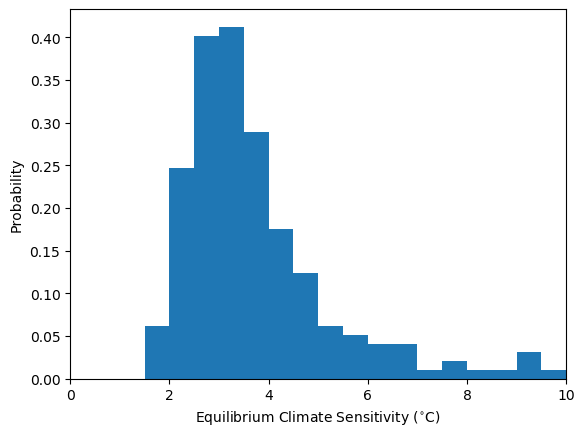

In [181]:
hist(ECS_samples, bins=0.:0.5:10., density=true)
xlim([0,10])
xlabel(L"Equilibrium Climate Sensitivity ($^{\circ}$C)")
ylabel("Probability");

In [182]:
ensemble = Dict{String, ClimateModel}();

for member_id in 1:length(ECS_samples)
    model = ClimateModel(ECS=ECS_samples[member_id]);
    ensemble[string(member_id)] = model
end

In [183]:
function optimize_stochastic_controls!(
        ensemble::Dict{String, ClimateModel};
        obj_option = "temp", temp_goal = 2., overshoot_prob = 1. /3., budget=10., expenditure = 0.5,
        max_deployment = Dict("mitigate"=>1., "remove"=>1., "geoeng"=>1., "adapt"=>1.),
        maxslope = Dict("mitigate"=>1. /20., "remove"=>1. /40., "geoeng"=>1. /20., "adapt"=>1. /20.),
        temp_final = nothing,
        start_deployment = Dict(
            "mitigate"=>collect(values(ensemble))[1].domain[1],
            "remove"=>collect(values(ensemble))[1].domain[1]+20,
            "geoeng"=> collect(values(ensemble))[1].domain[1]+40,
            "adapt"=>collect(values(ensemble))[1].domain[1]
        ),
        cost_exponent = 2
    )
    
    models = collect(values(ensemble))
    model_example = models[1]
    
    if length(models) == 1; overshoot_prob = 0.95; end

    model_optimizer = Model(optimizer_with_attributes(Ipopt.Optimizer,
            "acceptable_tol" => 1.e-8, "max_iter" => Int64(1e6),
            "print_frequency_iter" => 50,  "print_timing_statistics" => "yes"
    ))#, "print_level" => 0))
    
    f_JuMP(α) = α^cost_exponent
    register(model_optimizer, :f_JuMP, 1, f_JuMP, autodiff=true)

    function log_JuMP(x)
        if x == 0
            return -1000.0
        else
            return log(x)
        end
    end
    register(model_optimizer, :log_JuMP, 1, log_JuMP, autodiff=true)
    
    function below_temp_goal_JuMP(x)
        return (erf(
                sqrt(pi)/2. * (x .- 1.025*(model_example.economics.β * temp_goal^2)) * 5
                ) .+ 1.) * 0.5
    end
    register(model_optimizer, :below_temp_goal_JuMP, 1, below_temp_goal_JuMP, autodiff=true)

    function discounting_JuMP(t)
        if t < model_example.present_year
            return 0.
        else
            return (
                (1. .+ model_example.economics.utility_discount_rate) .^
                (-(t .- model_example.present_year))
            )
        end
    end

    register(model_optimizer, :discounting_JuMP, 1, discounting_JuMP, autodiff=true)

    q = [model.economics.baseline_emissions for (key, model) in ensemble]
    N = length(model_example.domain)
    E = length(ensemble)
    
    # constraints on control variables
    @variables(model_optimizer, begin
            0. <= M[1:N] <= max_deployment["mitigate"]  # emissions reductions
            0. <= R[1:N] <= max_deployment["remove"]  # negative emissions
            0. <= G[1:N] <= max_deployment["geoeng"]  # geoengineering
            0. <= A[1:N] <= max_deployment["adapt"]  # adapt
    end)
    
    control_vars = Dict(
        "mitigate" => M,
        "remove" => R,
        "geoeng" => G,
        "adapt" => A
    )
    
    controls = Dict(
        "mitigate" => model_example.controls.mitigate,
        "remove" => model_example.controls.remove,
        "geoeng" => model_example.controls.geoeng,
        "adapt" => model_example.controls.adapt
    )
    
    domain_tidx = (model_example.domain .>= model_example.present_year)
    
    M₀ = model_example.economics.mitigate_init
    R₀ = model_example.economics.remove_init
    G₀ = model_example.economics.geoeng_init
    A₀ = model_example.economics.adapt_init
    
    control_inits = Dict(
        "mitigate" => M₀,
        "remove" => R₀,
        "geoeng" => G₀,
        "adapt" => A₀
    )
    
    for (ckey, control) in control_vars
        fix(control_vars[ckey][1], control_inits[ckey]; force = true)

        for tidx in 2:N
            if tidx <= length(model_example.domain[.~domain_tidx])
                fix(control_vars[ckey][tidx], controls[ckey][tidx]; force = true)
            else
                if model_example.domain[tidx] < start_deployment[ckey]
                    fix(control_vars[ckey][tidx], control_inits[ckey]; force = true)
                end
            end
        end
    end
        
    # add integral function as a new variable defined by first order finite differences
    @variable(model_optimizer, cumsum_qMR[1:N, 1:E]);
    for (j, model) in enumerate(values(ensemble))
        for i in 1:N-1
            @constraint(
                model_optimizer, cumsum_qMR[i+1, j] - cumsum_qMR[i, j] ==
                (model.dt * (q[j][i+1] * (1. - M[i+1]) - q[j][1] * R[i+1]))
            )
        end
        @constraint(
            model_optimizer, cumsum_qMR[1, j] == 
            (model.dt * (q[j][1] * (1. - M[1]) - q[j][1] * R[1]))
        );
    
    end
    
    # Add constraint of rate of changes
    if typeof(maxslope) == Float64
        @variables(model_optimizer, begin
                -maxslope <= dMdt[1:N-1] <= maxslope
                -maxslope <= dRdt[1:N-1] <= maxslope
                -maxslope <= dGdt[1:N-1] <= maxslope
                -maxslope <= dAdt[1:N-1] <= maxslope
        end);
    elseif typeof(maxslope) == Dict{String,Float64}
        @variables(model_optimizer, begin
                -maxslope["mitigate"] <= dMdt[1:N-1] <= maxslope["mitigate"]
                -maxslope["remove"] <= dRdt[1:N-1] <= maxslope["remove"]
                -maxslope["geoeng"] <= dGdt[1:N-1] <= maxslope["geoeng"]
                -maxslope["adapt"] <= dAdt[1:N-1] <= maxslope["adapt"]
        end);
    end
    for i in 1:N-1
        @constraint(model_optimizer, dMdt[i] == (M[i+1] - M[i]) / model_example.dt)
        @constraint(model_optimizer, dRdt[i] == (R[i+1] - R[i]) / model_example.dt)
        @constraint(model_optimizer, dGdt[i] == (G[i+1] - G[i]) / model_example.dt)
        @constraint(model_optimizer, dAdt[i] == (A[i+1] - A[i]) / model_example.dt)
    end

    # add temperature kernel as new variable defined by first order finite difference
    @variable(model_optimizer, cumsum_KFdt[1:N, 1:E]);
    
    for (j, model) in enumerate(values(ensemble))
        for i in 1:N-1
            @NLconstraint(
                model_optimizer, cumsum_KFdt[i+1, j] - cumsum_KFdt[i, j] ==
                (
                    model.dt *
                    exp( - model.domain[i+1] / model.physics.τs ) *
                    5.35 * log_JuMP(
                        (model.physics.CO₂_init + cumsum_qMR[i+1, j]) /
                        (model.physics.CO₂_init + cumsum_qMR[1, j])
                    ) * (60. * 60. * 24. * 365.25)
                )
            )
        end
        @constraint(
            model_optimizer, cumsum_KFdt[1, j] == 0.
        );
    end
    
    @NLobjective(model_optimizer, Min,
        sum(
            sum(
                (
                    models[j].economics.mitigate_cost * f_JuMP(M[i]) +
                    models[j].economics.remove_cost * f_JuMP(R[i]) +
                    models[j].economics.geoeng_cost * f_JuMP(G[i]) +
                    models[j].economics.adapt_cost * f_JuMP(A[i])
                ) *
                discounting_JuMP(models[j].domain[i]) *
                models[j].dt
            for i=1:N)
        for j=1:E)
    )

    print(overshoot_prob * E)
    for i in 1:N
        @NLconstraint(model_optimizer,
            sum(below_temp_goal_JuMP(
                (1 - A[i]) * models[j].economics.β * (
                    (models[j].physics.δT_init + 
                    (
                        5.35 * log_JuMP(
                            (models[j].physics.CO₂_init + cumsum_qMR[i, j]) /
                            (models[j].physics.CO₂_init + cumsum_qMR[1, j])
                        ) * (60. * 60. * 24. * 365.25) + models[j].physics.γ *
                        (models[j].physics.τs * models[j].physics.B)^(-1) *
                        exp( ( models[j].domain[i] / models[j].physics.τs )) *
                        cumsum_KFdt[i, j]
                    ) * (models[j].physics.B + models[j].physics.γ)^-1
                ) * (1. - G[i])
                )^2
            ) for j=1:E) <= (overshoot_prob * E)
        )
    end
    
    optimize!(model_optimizer)
    print(termination_status(model_optimizer))

    for (j, model) in enumerate(values(ensemble))
        getfield(model.controls, :mitigate)[domain_tidx] = value.(M)[domain_tidx]
        getfield(model.controls, :remove)[domain_tidx] = value.(R)[domain_tidx]
        getfield(model.controls, :geoeng)[domain_tidx] = value.(G)[domain_tidx]
        getfield(model.controls, :adapt)[domain_tidx] = value.(A)[domain_tidx]
    end
    
    return model_optimizer
end

optimize_stochastic_controls! (generic function with 1 method)

In [ ]:
m = optimize_stochastic_controls!(ensemble, temp_goal = 2.0);
print(termination_status(m))
print(raw_status(m))

In [ ]:
plot_ensemble(ensemble)

In [ ]:
mean_model = ClimateModel(ECS=ECS_mean);
optimize_stochastic_controls!(Dict("mean-model" => mean_model));

In [ ]:
plot_ensemble(ensemble)
plot_state(mean_model, new_figure=false, plot_legends=false)

In [ ]:
plot_state(mean_model, new_figure=true, plot_legends=true)